<a href="https://colab.research.google.com/github/RondinellyMorais/Data-Science-projects/blob/main/C%C3%B3pia_de_Emprestimo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de previsão de empréstimo 

![oi](loan.jpg)

### Simuladores de empréstimos online são muito utilizados por bancos como indicadores aproximados de aprovação de crédito. Sendo que esta ferramenta vem se tornando muito popular entre os usuários. Para que os algoritmos possam fazer alguma  tipo de previsão usamos dados relacionados a informações dos clientes que solicitam um empréstimo tais como renda, valor do empréstimo, prazo de financiamento etc. Contudo obter dados suficientes para validarmos os modelos de previsão nem sempre é uma tarefa fácil. Pois, geralmente os dados apresentam valores ausentes, bem como dados desbalanceados. Desse modo podemos nos perguntar se é possível construir modelos de previsão  eficientes com uma pequena base de dados? Então, teremos como objetivos principais:
* ### Usar um dataset pequeno para testarmos a eficiência de um modelo de machine learning para previsão de aprovação de empréstimo.
* ### Tunar os hiperparâmetros do modelo de machine learning 
* ### Usar o modelo de previsão para construir um aplicativo em streamlit

### Nesse notebook seguiremos o seguinte roteiro:
### Iniciaremos com uma análise exploratória de dados para extrair insights básicos dos dados.

### Em nossa análise usamos o modelo de machine learning LGBMclassifier para fazer as previsões. O LGBMclassifier é um algoritimo de gradiente boost baseado em árvore de decisão. Esse algoritmo tem vantagem ter alta velocidade de treino dos dados, baixo uso de memória e uma melhor acurácia https://www.kaggle.com/prashant111/lightgbm-classifier-in-python.

### Para validar nosso modelo uma boa opção é a métrica roc_auc_score, sendo essa uma excelente ferramenta para avaliar modelos de classíficação. Podemos aprender mais sobre a roc_auc_score nesse link https://medium.com/data-hackers/como-avaliar-seu-modelo-de-classifica%C3%A7%C3%A3o-34e6f6011108.

### Usando a função dummy_minimize tunaremos os hiperparâmetros do LGBMclassifier para obter uma melhoria do nosso modelo.

## Sumário
### 1 Extraindo os dados
### 1.1 Exibindo as informações gerais 
### 1.2 Visualização de dados e pré-processamento
### 1.2.1 Colunas numéricas 
### 1.2.2 Resolvendo o problema dos valores ausentes nas colunas númericas
### 1.2.3 Colunas categóricas
### 1.2.4 Outras visualizações
### 1.2.5 Agrupando variáveis numéricas
### 1.2.6 Correlação das colunas numéricas
### 2 Transformando os dados
### 2.1 Encodando as colunas categoricas
### 2.2 Normalizando os dados 
### 3 Rodando os dados
### 3.1 Importando o modelo de machine learning
### 3.2 Tunando os hiperparâmetros
### 3.3 Definindo o modelo tunado
### 3.4 Salvando modelo de machine learning


# Carregando as bibliotecas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import pickle
from skopt import dummy_minimize
from sklearn.metrics import roc_auc_score

import plotly.express as px
from plotly.offline import iplot

# 1 Extraindo os dados

In [ ]:
# Esse comando ignora os avisos de algumas funções
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# carregando o dataset e atribuindo ao objeto df
df = pd.read_csv('Loan_Home.csv')

In [ ]:
# Exibindo os dados do dataset
df.head(4)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y


## 1.1 Exibindo as informações gerais 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


### Vemos que as colunas 'Gender', 'Married', 'Dependents', 'Self_Employed', 'LoanAmount', 'Loan_Amount_Term' e 'Credit_History' possuem valores ausentes. Vamos tratar essas valores ausentes mais adiante.

## 1.2 Visualização de dados e preprocessamento

## 1.2.1 Colunas númericas 

In [ ]:
# Alguns valores estatísticos das colunas numéricas
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


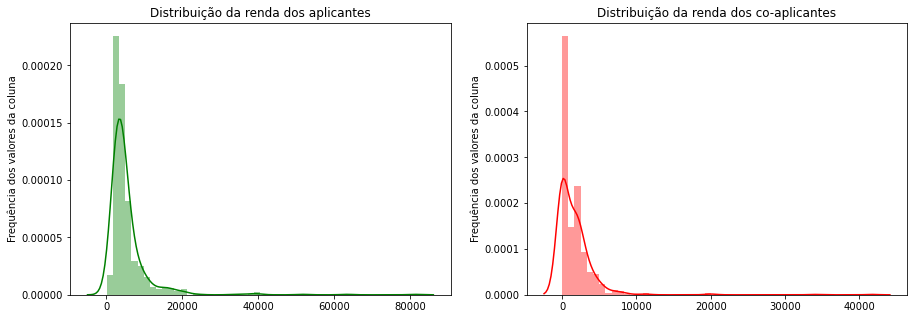

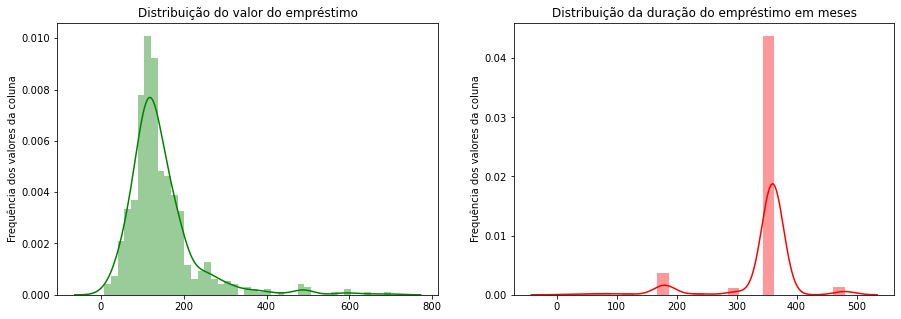

In [ ]:
# Plotando a distruição dos valores das colunas numéricas
plt.figure(figsize=(15,5))


plt.subplot(1,2,1)
ex1= sns.distplot(df['ApplicantIncome'], color = 'g')
plt.title("Distribuição da renda dos aplicantes")
ex1.set(xlabel = '', ylabel="Frequência dos valores da coluna")

plt.subplot(1,2,2)
ex1= sns.distplot(df['CoapplicantIncome'], color ='r')
plt.title("Distribuição da renda dos co-aplicantes")
ex1.set(xlabel = '', ylabel='Frequência dos valores da coluna')

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ex1= sns.distplot(df['LoanAmount'], color = 'g')
plt.title("Distribuição do valor do empréstimo")
ex1.set(xlabel = '', ylabel="Frequência dos valores da coluna")

plt.subplot(1,2,2)
ex1= sns.distplot(df['Loan_Amount_Term'], color ='r')
plt.title("Distribuição da duração do empréstimo em meses")
ex1.set(xlabel = '', ylabel='Frequência dos valores da coluna')
   
plt.show()

### A destruição dos valores que representam a duração do empréstimo esta fortemente concentrada no intervalo de 300 a 400 meses de duração. As demais colunas numéricas tem suas respectivas destruições mais homogêneas.

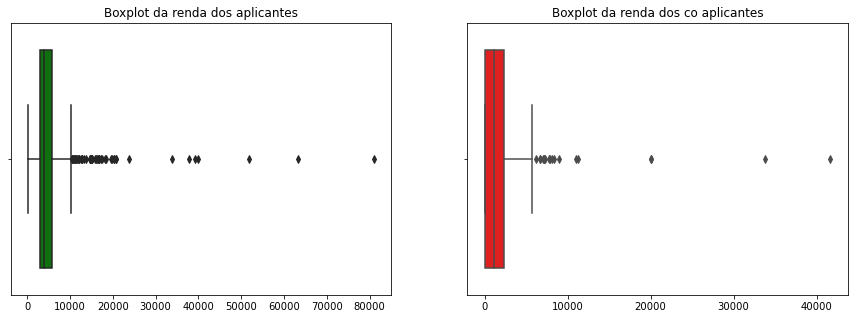

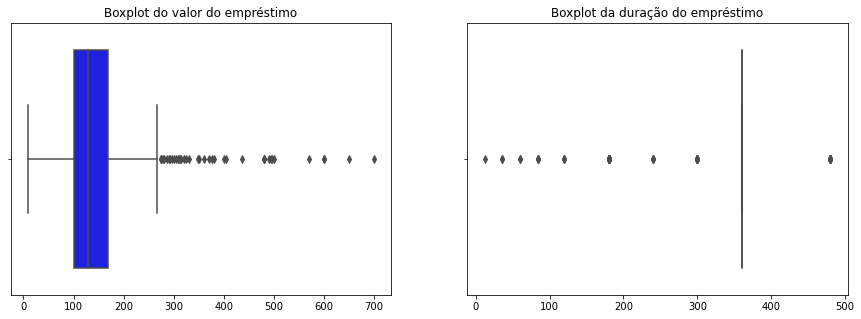

In [ ]:
# Construindo os boxplots
plt.figure(figsize=(15,5))


plt.subplot(1,2,1)
ex1= sns.boxplot(df['ApplicantIncome'], color = 'g')
plt.title("Boxplot da renda dos aplicantes")
ex1.set(xlabel = '', ylabel="")

plt.subplot(1,2,2)
ex1= sns.boxplot(df['CoapplicantIncome'], color ='r')
plt.title("Boxplot da renda dos co aplicantes")
ex1.set(xlabel = '', ylabel='')

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ex1= sns.boxplot(df['LoanAmount'], color = 'b')
plt.title("Boxplot do valor do empréstimo")
ex1.set(xlabel = '', ylabel="")

plt.subplot(1,2,2)
ex1= sns.boxplot(df['Loan_Amount_Term'], color ='r')
plt.title("Boxplot da duração do empréstimo")
ex1.set(xlabel = '', ylabel='')
   
plt.show()

### Ambos os boxplots mostram que há presença de muitos outliers. Sendo que os valores atribuidos a coluna da duração do empréstimento (Loan_Amount_Term) são os mais significativos de todos. Normalmente teriamos de eliminar esses dados discrepantes, contudo como nossa base de dados é bem pequena é natural esperar tais valores. Por isso devemos manter esses dados para serem usados no modelo de previsão.

## 1.2.2 Resolvendo o problema dos valores ausentes nas colunas numéricas

In [ ]:
# Determinando a proporção dos valores nulos nas colunas
a = (df.isnull().sum() / df.shape[0] * 100)['LoanAmount']
b = (df.isnull().sum() / df.shape[0] * 100)['Loan_Amount_Term']
c = (df.isnull().sum() / df.shape[0] * 100)['Credit_History']
print("Porcentagem de valores nulos em 'LoanAmount': {:.2f} %".format(a))
print("Porcentagem de valores nulos  em 'Loan_Amount_Term': {:.2f} %".format(b))
print("Porcentagem de valores nulos  em 'Credit_History': {:.2f} %".format(c))

Porcentagem de valores nulos em 'LoanAmount': 3.58 %
Porcentagem de valores nulos  em 'Loan_Amount_Term': 2.28 %
Porcentagem de valores nulos  em 'Credit_History': 8.14 %


### Nas colunas analisadas, menos de 10% das linhas possuem valores nulos. Então, é razoável preenchermos essas ausencias com a mediana dos valores não nulos.

In [ ]:
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].mean())

In [ ]:
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean())

In [ ]:
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mean())

### A coluna 'Credit_History' atribui valor 1 para quem tem histórico de crédito e 0 para que não possui. Vamos analisar esse coluna para ver se todos os valores são apenas 0 ou 1.

In [ ]:
df['Credit_History'].unique()

array([1.        , 0.        , 0.84219858])

### Existe apresença de valores que não corresponde aos valores 1 e 0. 

In [ ]:
# Exibindo valores anômalos
df[df['Credit_History']==0.8421985815602837].iloc[:3]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
16,LP001034,Male,No,1,Not Graduate,No,3596,0.0,100.0,240.0,0.842199,Urban,Y
24,LP001052,Male,Yes,1,Graduate,NaN,3717,2925.0,151.0,360.0,0.842199,Semiurban,N
30,LP001091,Male,Yes,1,Graduate,NaN,4166,3369.0,201.0,360.0,0.842199,Urban,N


### Para eliminar esses valores anômalos primeiro temos que determinar a proporção desses valores com os demais da coluna 

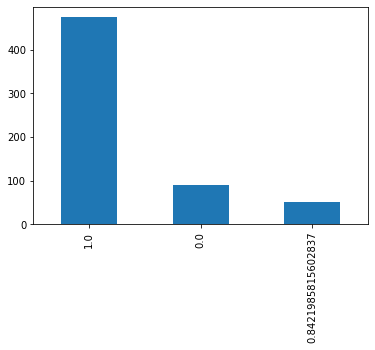

In [ ]:
df['Credit_History'].value_counts().plot(kind= 'bar')
plt.show()

### Como os valores anômalos é muito menor do que o valor predominante 1, então podemos susbstitui-los por esse mesmo valor 1.

In [ ]:
df['Credit_History'] = df['Credit_History'].replace({0.8421985815602837: 1})

## 1.2.3 Colunas categóricas

### Analisando primeiro as colunas categóricas sem valores ausentes.

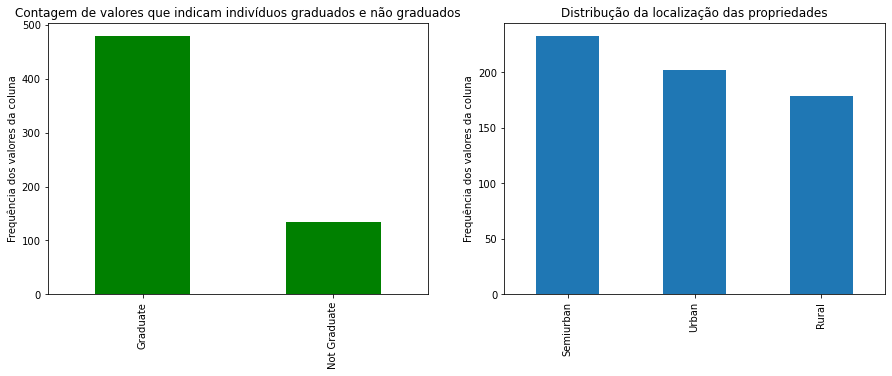

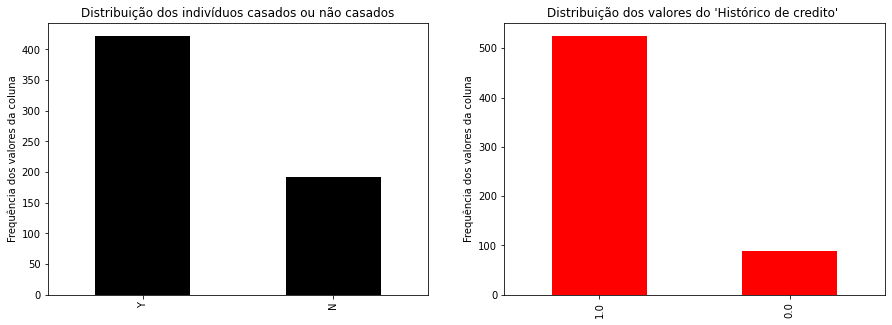

In [ ]:
# Dados categóricos sem valores ausentes
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ex1= df['Education'].value_counts().plot(kind='bar', color = 'g')
plt.title("Contagem de valores que indicam indivíduos graduados e não graduados")
ex1.set(xlabel = '', ylabel="Frequência dos valores da coluna")

plt.subplot(1,2,2)
ex1= df['Property_Area'].value_counts().plot(kind='bar')
plt.title("Distribução da localização das propriedades")
ex1.set(xlabel = '', ylabel="Frequência dos valores da coluna")

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ex1= df['Loan_Status'].value_counts().plot(kind='bar', color = 'k')
plt.title("Distribuição dos indivíduos casados ou não casados")
ex1.set(xlabel = '', ylabel="Frequência dos valores da coluna")

plt.subplot(1,2,2)
ex1= df['Credit_History'].value_counts().plot(kind='bar', color = 'r')
plt.title("Distribuição dos valores do 'Histórico de credito' ")
ex1.set(xlabel = '', ylabel='Frequência dos valores da coluna')

plt.show()

### Dos plots das colunas categóricas acima podemos verificar que a coluna os valores 'Property_Area' são mais desbalanceadas que as demais.

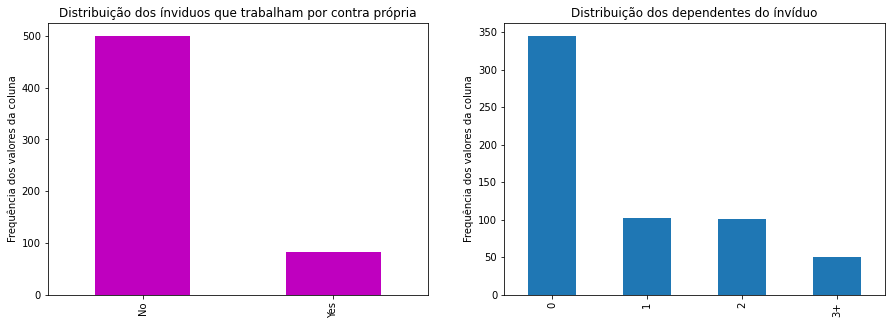

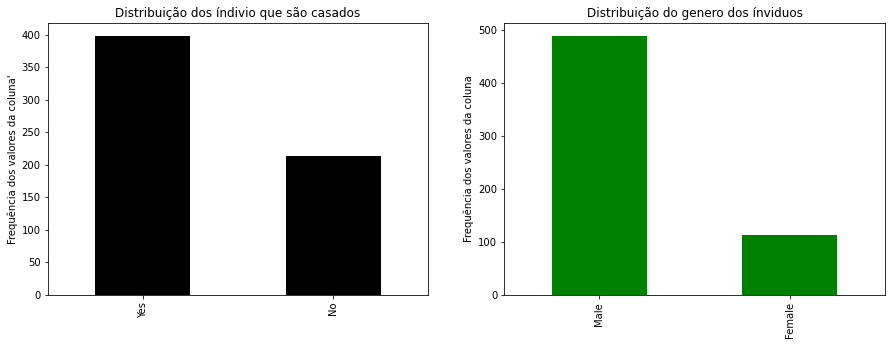

In [ ]:
# Dados  categóricos com valores ausentes
plt.figure(figsize=(15,5))


plt.subplot(1,2,1)
ex1= df['Self_Employed'].value_counts().plot(kind='bar', color = 'm')
plt.title("Distribuição dos ínviduos que trabalham por contra própria")
ex1.set(xlabel = '', ylabel="Frequência dos valores da coluna")

plt.subplot(1,2,2)
ex1= df['Dependents'].value_counts().plot(kind='bar')
plt.title("Distribuição dos dependentes do ínvíduo")
ex1.set(xlabel = '', ylabel='Frequência dos valores da coluna')

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ex1= df['Married'].value_counts().plot(kind='bar', color = 'k')
plt.title("Distribuição dos índivio que são casados")
ex1.set(xlabel = '', ylabel="Frequência dos valores da coluna'")

plt.subplot(1,2,2)
ex1= df['Gender'].value_counts().plot(kind='bar', color = 'g')
plt.title("Distribuição do genero dos ínviduos")
ex1.set(xlabel = '', ylabel="Frequência dos valores da coluna")

plt.show()

### Dos valores das colunas categóricas plotadas acima verificamos que todas apresentam dados desbalanceados. Na coluna'Self_Employed' a grande maioria dos indivíduos não trabalham por contra própria. Sendo que a maior parte desses indivíduos sendo do gênero masculino. Interessante observar que a quantidade de indivíduos casados e não casados são razoavelmente balanceados, além do que a maioria não possuem dependentes.

In [ ]:
df['Self_Employed'] = df['Self_Employed'].fillna(df.mode()['Self_Employed'][0])

In [ ]:
df['Dependents'] = df['Dependents'].fillna(df.mode()['Dependents'][0])

In [ ]:
df['Gender'] = df['Gender'].fillna(df.mode()['Gender'][0])

### Tratamos os valores ausentes das últimas colunas categóricas com os valores mais frequentes das colunas.

### Usando o comando .info() verificamos que todas as colunas não possuem mais valores ausentes. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


## 1.2.4 Outras visualizações

### Existem diversos tipos de visualizações que podemos usar para explorarmos os dados, aqui vamos exibir todas as colunas categóricas em termos do status de aprovação do empréstimo. Listando todas as colunas categóricas e agrupando os plots em termos de 'Loan_Status':

In [ ]:
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area','Credit_History','Loan_Amount_Term']

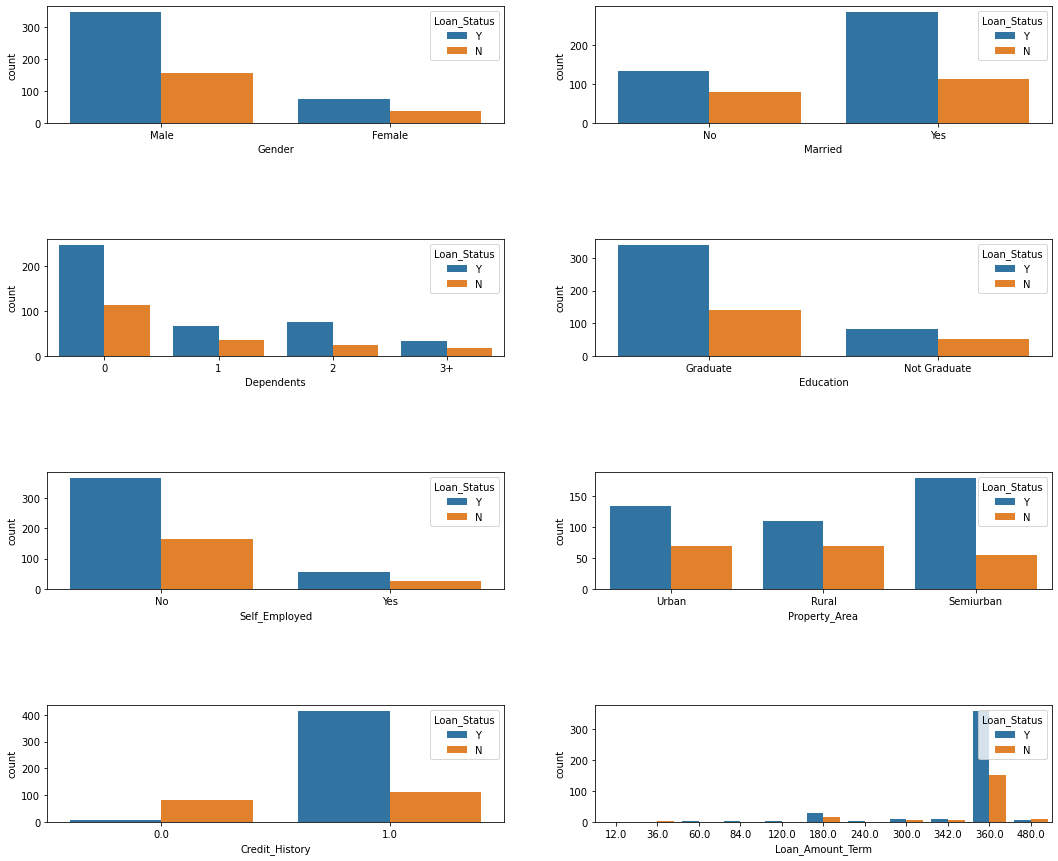

In [ ]:
fig,axes = plt.subplots(4,2,figsize=(18,15))
for idx,cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=df,hue='Loan_Status',ax=axes[row,col])


plt.subplots_adjust(hspace=1)

### - A primeira conclusão importante que chegamos é que em quase todas as situações
###   analisadas, com exceção da 'Credit_History', as aprovações são maioria.

### - Gênero: Aproximadamente três vezes das requisições de empréstimo são feitas por homens.

### - Matrimônio: Aproximadamente duas vezes das requisições de empréstimo são feitas por indivíduos
###   casados, do que os solteiros e ainda os casados tem pelo menos o dobro de chance de terem a solicitação aprovada.

### - Dependentes: Os indíviduos sem dependentes representam pelo menos três vezes mais solicitações do que os
###   demais. O interessante é que os indivíduos com dois dependentes tem uma maior taxa de aprovação.

### - Graduados: Aproximadamente três vezes mais invíduos solicitantes de empréstimo são graduados e tem uma 
### maior  chance de serem aprovados.

### - Trabalhador do autômano: Há quase cinco vezes mais solicitações de indivíduos que não trabalham por contra própria e estes tem maior 
###   chance de terem suas solicitações aprovadas do que autônomos.

### - Localização da propriedade: Os indiviíuos com propriedades localizadas nas regiões semiurbanas têm quase duas 
###   vezes mais chance de taxa de aprovação de empréstimo.

### - Histórico de credito: A grande maioria dos índividuos solicitantes têm algum histórico de crédito e têm muito
###   mais chance de serem aprovados do que aqueles que não tem histórico de crédito.

### - Tempo de pagamento: Constatamos que a maioria dos números de solicitações são para prazos longos, por volta de 
###   360 meses e estes têm maior chance de aprovação. O que nos leva a inferir que empréstimos de longo prazos são mais 
###   prováveis de serem aprovados.

## 1.2.5 Agrupando variáveis númericas

In [ ]:
# Agrupando as variáveis númericas usando o comando .groupby()
plot1 = df[['LoanAmount', 'Loan_Status',]].groupby('Loan_Status').sum().reset_index()
plot2 = df[['ApplicantIncome', 'Loan_Status',]].groupby('Loan_Status').sum().reset_index()
plot3 = df[['CoapplicantIncome', 'Loan_Status',]].groupby('Loan_Status').sum().reset_index()

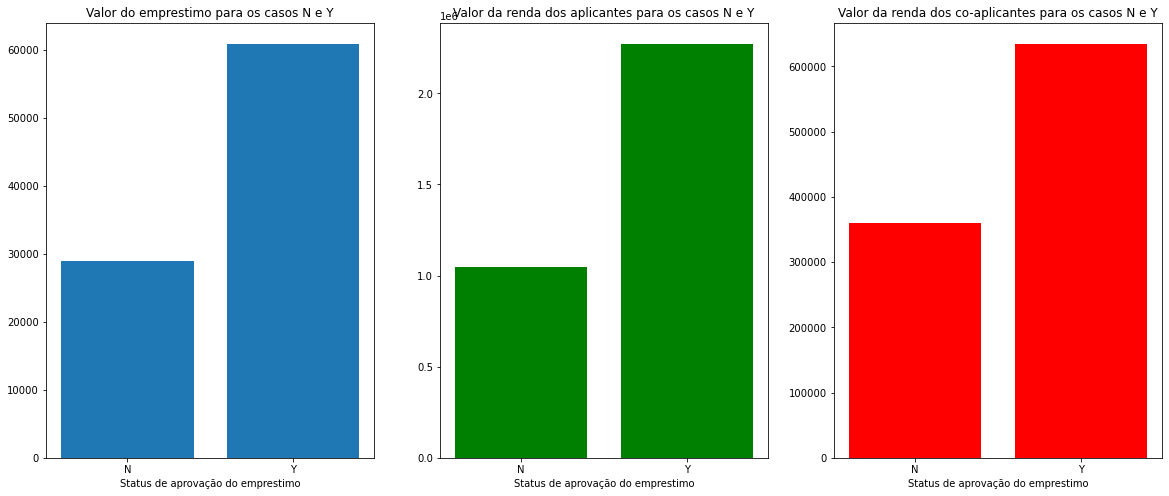

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.bar(plot1['Loan_Status'], plot1['LoanAmount'])
plt.title('Valor do emprestimo para os casos N e Y')
plt.xlabel("Status de aprovação do emprestimo")

plt.subplot(1,3,2) 
plt.bar(plot2['Loan_Status'], plot2['ApplicantIncome'], color ='g')
plt.title('Valor da renda dos aplicantes para os casos N e Y')
plt.xlabel("Status de aprovação do emprestimo")


plt.subplot(1,3,3) 
plt.bar(plot3['Loan_Status'], plot3['CoapplicantIncome'], color ='r')
plt.title('Valor da renda dos co-aplicantes para os casos N e Y')
plt.xlabel("Status de aprovação do emprestimo")

plt.show()

### Ao agruparmos todas colunas númericas em termos de status de empréstimo, verificamos que os maiores valores estão associados com aprovações positivas.


## 1.2.6 Correlação das colunas númericas

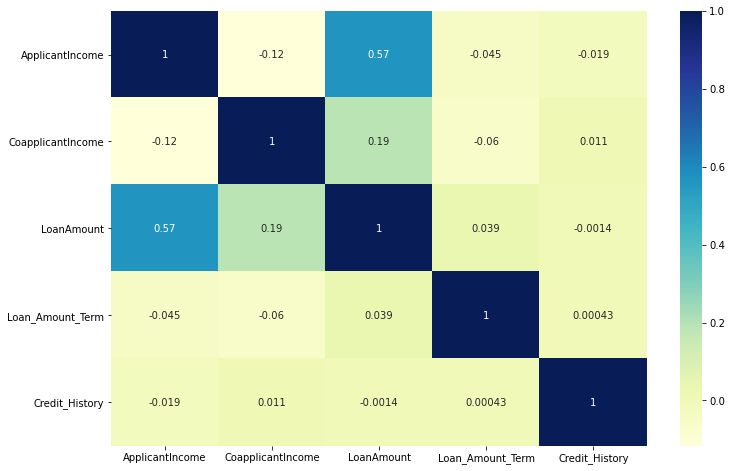

In [ ]:
plt.figure(figsize = (12, 8))
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")
plt.show()

### A coluna numérica que tem maior correlação com quantidade de dinheiro emprestado é a coluna 'renda do aplicante'.

# 2 Transformando os dados

## 2.1 Encodando as colunas categórias

### Primeiramente vamos eliminar a coluna 'Loan_ID' que não é necessária para alimentar o modelo de machine learning

In [ ]:
# Eliminando a coluna id
df = df.drop('Loan_ID', axis=1)

In [ ]:
# Separando as variáveis alvo e as features
X = df.drop('Loan_Status', axis = 1)
Y = df['Loan_Status']

In [ ]:
# Criando datasets treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3 )

### Para que o modelos de machine learning possar  ser aplicados aos nossos dados temos que converter os valores das colunas categóricas em valores numéricos. Como temos poucos valores únicos em cada coluna categórica é razoável usar OrdinalEncoder

In [ ]:
# usando OrinalEncoder nos dados de treino
ordinal = OrdinalEncoder()
x_train0 = ordinal.fit_transform(x_train)

In [ ]:
# usando OrinalEncoder nos dados de teste
ordinal = OrdinalEncoder()
x_test0 = ordinal.fit_transform(x_test)

## 2.2 Normalizando os dados 

### Normalizar os dados de teste e treino em  uma mesma escala permite que nossas dados sejam melhor compreendidos pelo modelo de machine learning

In [ ]:
# Aplicando a normalização nos dados de treino
scaler = StandardScaler().fit(x_train0)
x_train0 = scaler.transform(x_train0)

In [ ]:
# Aplicando a normalização nos dados de teste
scaler_test = StandardScaler().fit(x_test0)
x_test0 = scaler_test.transform(x_test0)

# 3 Rodando os dados

## 3.1 Importando o modelo de machine learning

### O  Light Gradient Boosted Machine é uma biblioteca que promove uma eficiente implememtação do algoritmo gradiente boost e o usaremos aqui para fazer nossas predições.

In [ ]:
# Definindo nosso modelo de machine learning
mdl = LGBMClassifier(random_state=0)
mdl.fit(x_train0, y_train)

LGBMClassifier(random_state=0)

In [ ]:
# Determinamos a probalidade de acerto usandos os dados de teste
p = mdl.predict_proba(x_test0)[:, 1]

In [ ]:
# Usando a métrica roc_auc_score para determinar a eficiência do nosso modelo
roc_auc_score(y_test, p)

0.7155781735934408

## 3.2 Tunando os hiperparêmetros

### É possível melhorar a eficiência do nosso modelo de previsão tunando  seus  hiperparâmetros usando para isso a função dummy minimaze. Construimos uma função que recebe os hiperparâmetros a serem otimizados e retorna uma lista com vários parâmetros. Dessa lista podelos selecionar os parâmetros com a melhor métrica de validação.

In [ ]:
# Criando a função de tune dos hiperparâmetros
def treinar_model(params):
    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]

    print(params, '\n')

    mdl = LGBMClassifier(learning_rate =learning_rate, num_leaves = num_leaves,  min_child_samples= min_child_samples
    , subsample = subsample, colsample_bytree= colsample_bytree, ramdom_state = 0, subsample_freq=1, n_estimators =100)
    mdl.fit(x_train0, y_train)

    p = mdl.predict_proba(x_test0)[:, 1]

    return -roc_auc_score(y_test, p)

# Aqui definimos os intervalos dos valores que os hiperparâmetros que queremos tunar podem assumir
space = [(1e-3, 1e-1, 'log-uniform'), # learning rate
(2, 128), # num_leaves
(1, 100), # min child samples
(0.05, 1.0), # subsample 
(0.1, 1.0)] # colsample bytree

resultado = dummy_minimize(treinar_model, space, random_state=1, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
[0.09871192514273254, 74, 10, 0.3372159440002478, 0.23208030173540176] 

[LightGBM] [Warning] Unknown parameter: ramdom_state
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0743
Function value obtained: -0.7409
Current minimum: -0.7409
Iteration No: 2 started. Evaluating function at random point.
[0.001529949829431263, 78, 72, 0.3782826906908954, 0.457090726807603] 

[LightGBM] [Warning] Unknown parameter: ramdom_state
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0337
Function value obtained: -0.4680
Current minimum: -0.7409
Iteration No: 3 started. Evaluating function at random point.
[0.01195730942971637, 128, 19, 0.5483207515942279, 0.49910760440160107] 

[LightGBM] [Warning] Unknown parameter: ramdom_state
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0753
Function value obtained: -0.6568
Current minimum: -0.7409
Iteration No: 4 started. Evaluating f

In [ ]:
# Aqui selecionamos os melhores parâmetros para tunar nosso modelo
resultado.x

[0.0014697585967435188, 40, 9, 0.9149259627034465, 0.36903710098874454]

## 3.3 Definindo o modelo tunado

In [ ]:
# Agora temos de passar os hiperparâmetros com os melhores valores
mdl_best = LGBMClassifier(learning_rate= 0.00147, num_leaves= 40, min_child_samples = 9 , subsample = 0.91493
,colsample_bytree = 0.36904 , random_state=0)
mdl_best.fit(x_train0, y_train)

LGBMClassifier(colsample_bytree=0.36904, learning_rate=0.00147,
               min_child_samples=9, num_leaves=40, random_state=0,
               subsample=0.91493)

In [ ]:
# A efiência do nosso modelo agora é 
p = mdl_best.predict_proba(x_test0)[:, 1]
roc_auc_score(y_test, p)

0.7403166525303929

### Obtivemos nessa rodada uma eficiência de 74.03% contra 71.56% do modelo não tunado, podendo esse diferença variar com as rodadas.

## 3.4 Salvando modelo de machine learning

### Usaremos os dados de teste para construir o dataset que alimentará nossso aplicativo streamlit

In [ ]:
# Criando o dataset e salvando externamente em extenção .csv
data = pd.concat([x_test, y_test], axis=1)
data.to_csv('emprestimo_app.csv', index = False)

### Finalmente salvamos nosso modelo treinado e tunado numa  extensão .pkl para predição dos valores de input do aplicativo streamlit 

In [ ]:
# Escrevendo o modelo em extensão .pkl
import pickle
pickle.dump(mdl_best, open('mdl_best.pkl', 'wb'))